In [1]:
import sys
sys.path.insert(1, 'BATTERY_GITHUB')
import eval_utils
import pre_process_utils
# import BATTERY_GITHUB.pre_process_utils as pre_process_utils
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)

2024-05-04 10:57:53.376352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [135]:
import importlib
importlib.reload(eval_utils)

<module 'eval_utils' from '/baja/BATTERY_GITHUB/eval_utils.py'>

# Load data

In [3]:
# HI DATA
data = np.load('Data/Battery/Load_data_big_sameT/processed_data_2post_200_60RUL.npz')
Voltage_windows = data['Voltage_windows']
Cycles_windows = data['Cycles_windows']
Units_windows = data['Units_windows']
Current_windows = data['Current_windows']
Cycles_windows_2 = data['Cycles_windows_2']
HI_windows = data['HI_windows']
Temp_windows = data['Temp_windows']
Time_windows = data['Time_windows']



data = np.load('Data/Battery/Load_data_big_sameT/processed_data_2post_test_200_60RUL.npz')
Voltage_windows_test = data['Voltage_windows_test']
Cycles_windows_test = data['Cycles_windows_test']
Units_windows_test = data['Units_windows_test']
Current_windows_test = data['Current_windows_test']
Cycles_windows_2_test = data['Cycles_windows_2_test']
HI_windows_test = data['HI_windows_test']   
Temp_windows_test = data['Temp_windows_test']
Time_windows_test = data['Time_windows_test']

In [4]:
Y_windows = pre_process_utils.RUL_maker(Cycles_windows,Units_windows).reshape(-1,1)
Y_windows_test = pre_process_utils.RUL_maker(Cycles_windows_test,Units_windows_test).reshape(-1,1)

HI_windows = HI_windows[:,0]
HI_windows_test = HI_windows_test[:,0]

#Convert to SOH%
MANUFACTURE_CAPACITY = 2.1
HI_windows = HI_windows/MANUFACTURE_CAPACITY
HI_windows_test = HI_windows_test/MANUFACTURE_CAPACITY

In [72]:
V_T = np.concatenate((Voltage_windows, Temp_windows), axis=-1)
V_T_test = np.concatenate((Voltage_windows_test,Temp_windows_test),axis = -1)

In [31]:
Temp_windows_test.shape

(150844, 200, 1)

In [28]:
print(V_T.shape,V_T_test.shape)

(418317, 200, 2) (150844, 200, 2)


In [7]:
print(np.unique(Units_windows))
print(np.unique(Units_windows_test))

[ 1.  4.  5.  7. 13. 14. 15. 17. 19.]
[ 6.  8. 16. 20.]


# Residual A

In [8]:
HI_windows.shape

(418317, 1)

In [70]:
def H_index_residual_A(latent_dims,Window_size = 100):
    
    x_dim = 2
    w_dim = 1
    
    inpX = tf.keras.layers.Input(shape=(Window_size,x_dim),name = 'InpX')
    inpW = tf.keras.layers.Input(shape=(Window_size,w_dim),name = 'inpW')
    x = tf.concat([inpX,inpW],axis = -1)
    for i in latent_dims:
        x=tf.keras.layers.Conv1D(i,15,strides=1,activation='relu',padding = 'same')(x)
    x = tf.keras.layers.Dense(x_dim)(x)
    # x=tf.keras.layers.Conv1D(x_dim,15,strides=1,activation='linear',padding = 'same')(x)   
    model = tf.keras.models.Model([inpX,inpW],x)
    return model



In [93]:
model_type = 'A'
layers=[64,64,64]
Window_size = Voltage_windows.shape[1]
model = H_index_residual_A(layers,Window_size)

In [94]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_residual_model(model_type,
                                            V_T, Current_windows, Cycles_windows,Cycles_windows_2, Units_windows, Y_windows,HI_windows,
                                             V_T_test, Current_windows_test, Cycles_windows_test,Cycles_windows_2_test, Units_windows_test, Y_windows_test,HI_windows_test,
                                             model,healthy_thresholds = [100],runs = 1, epochs = 10, batch_size=1024,learning_rate = 0.001,reset_weights = True)

RUN#:  0
reset_weights
75/75 [==============================] - 2s 26ms/step
{'MAE_TR': [6.931118161355966], 'MAPE_TR': [9.228408514368331], 'M_TR': [0.3434277414669571], 'T_TR': [0.4643765975876623], 'FC_TR': [0.36772306727796095], 'MI_TR': [0.5045938022520673], 'MAE_TS': [9.139587609910986], 'MAPE_TS': [12.56695593528959], 'M_TS': [0.3321661998132587], 'T_TS': [0.2285751142562287], 'FC_TS': [0.4182043269038173], 'MI_TS': [0.5052592272067822], 'TIME': [61.30591797828674], 'I': [100]}


In [95]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,6.931118,9.228409,0.343428,0.464377,0.367723,0.504594,9.139588,12.566956,0.332166,0.228575,0.418204,0.505259,61.305918,100


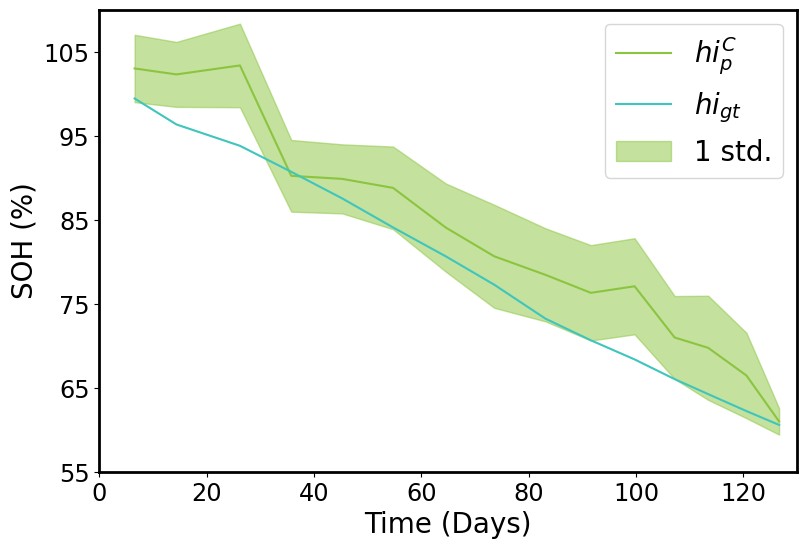

In [97]:
Unit = 20
run_id = 0
hh ,units_smooth, cycles_smooth = eval_utils.smooth_per_cycle(HI_windows_test,Cycles_windows_2_test[:,0],Units_windows_test)
hh = hh*100

t = Time_windows_test[:,0]
t = eval_utils.smooth_per_cycle(t,Cycles_windows_2_test[:,0],Units_windows_test)[0]
t = t/3600/24


idx2 = np.ravel(units_smooth==Unit)

fig = plt.figure()
plt.plot(t[idx2],z_test[run_id][idx2],'#8BC53F',label = r'$hi_{p}^C$')
plt.plot(t[idx2],hh[idx2],'#3FC5BC',label = r'$hi_{gt}$')

plt.fill_between(t[idx2],(z_test[run_id][idx2]-z_test_std[run_id][idx2]), 
                        (z_test[run_id][idx2]+z_test_std[run_id][idx2]), alpha = 0.5,color = '#8BC53F',label='1 std.')
plt.legend()
plt.xlabel('Time (Days)')
plt.ylabel('SOH (%)')
plt.ylim(55,110)
plt.xlim(0,130)
plt.yticks(np.arange(55, 115, 10))
plt.show()

# Residual B

In [169]:
def H_index_residual_B(latent_dims,Window_size = 100):
    
    x_dim = 2
    w_dim = 1
    inpW = tf.keras.layers.Input(shape=(Window_size,w_dim),name = 'inpW')
    x = inpW
    for i in latent_dims:
        x = tf.keras.layers.Conv1D(i,11,strides=1,activation='relu',padding = 'same')(x)
    x = tf.keras.layers.Dense(x_dim)(x)
    model = tf.keras.models.Model(inpW,x)
    return model



In [172]:
model_type = 'B'
layers=[8,8,8]
layers=[64,64,64]
Window_size = Voltage_windows.shape[1]
modelB = H_index_residual_B(layers,Window_size)

In [ ]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_residual_model(model_type,V_T, Current_windows, Cycles_windows,Cycles_windows_2, Units_windows, Y_windows,HI_windows,
                                                                                                    V_T_test, Current_windows_test, Cycles_windows_test,Cycles_windows_2_test, Units_windows_test, Y_windows_test,HI_windows_test,
                                             modelB,healthy_thresholds = [100],runs = 1, epochs = 25, batch_size=2024,learning_rate = 0.001,reset_weights=True)

In [133]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,14.023373,17.427884,0.227894,0.516273,1.575801,0.351996,13.102199,16.548281,0.205182,0.407566,0.368563,0.252306,98.755564,100


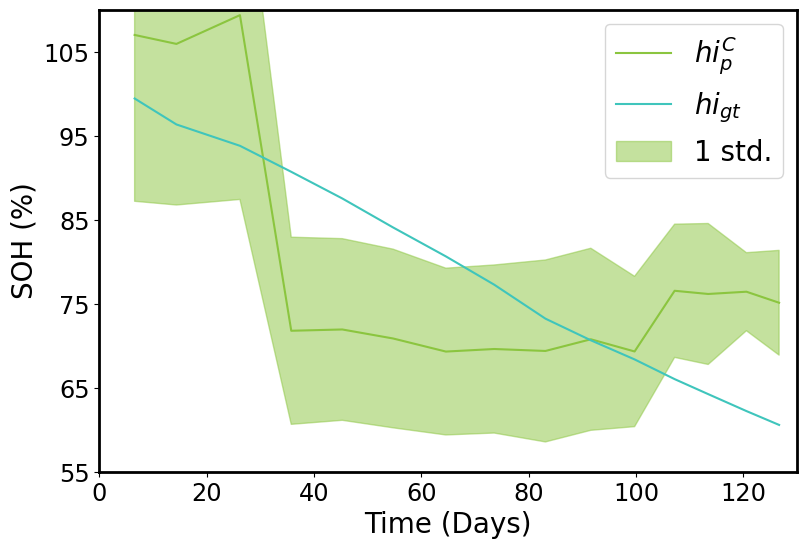

In [102]:
Unit = 20
run_id = 0
hh ,units_smooth, cycles_smooth = eval_utils.smooth_per_cycle(HI_windows_test,Cycles_windows_2_test[:,0],Units_windows_test)
hh = hh*100

t = Time_windows_test[:,0]
t = eval_utils.smooth_per_cycle(t,Cycles_windows_2_test[:,0],Units_windows_test)[0]
t = t/3600/24


idx2 = np.ravel(units_smooth==Unit)

fig = plt.figure()
plt.plot(t[idx2],z_test[run_id][idx2],'#8BC53F',label = r'$hi_{p}^C$')
plt.plot(t[idx2],hh[idx2],'#3FC5BC',label = r'$hi_{gt}$')

plt.fill_between(t[idx2],(z_test[run_id][idx2]-z_test_std[run_id][idx2]), 
                        (z_test[run_id][idx2]+z_test_std[run_id][idx2]), alpha = 0.5,color = '#8BC53F',label='1 std.')
plt.legend()
plt.xlabel('Time (Days)')
plt.ylabel('SOH (%)')
plt.ylim(55,110)
plt.xlim(0,130)
plt.yticks(np.arange(55, 115, 10))
plt.show()

# Supervised

In [174]:
# Define a supervised model for predicting health index (HI)
def H_index_residual_supervised(latent_dims, Window_size):
    # Define the dimensions of input data
    x_dim = 2  # Dimensionality of sensor data (X)
    w_dim = 1   # Dimensionality of additional input data (W)
    h_dim = 1   # Dimensionality of the predicted health index (HI)

    # Define input layers for sensor data (X) and additional input data (W)
    inpX = tf.keras.layers.Input(shape=(Window_size, x_dim), name='InpX')
    inpW = tf.keras.layers.Input(shape=(Window_size, w_dim), name='inpW')
    
    # Concatenate sensor data (X) and additional input data (W) along the feature axis
    x = tf.concat([inpX, inpW], axis=-1)

    # Apply convolutional layers with specified latent dimensions
    for i in latent_dims:
        # Apply a 1D convolutional layer with i filters, relu activation, and same padding
        x = tf.keras.layers.Conv1D(i, 11, 1, activation='relu', padding='same')(x)
        # Apply batch normalization to stabilize and accelerate the training process
        x = tf.keras.layers.BatchNormalization()(x)
        # Apply max pooling to downsample the feature maps
        x = tf.keras.layers.MaxPooling1D()(x)

    # Flatten the output of convolutional layers
    x = tf.keras.layers.Flatten()(x)
    # Apply a fully connected dense layer to predict the health index (HI)
    x = tf.keras.layers.Dense(h_dim, name='X')(x)
    
    # Define the model with inputs (sensor data and additional input data) and output (predicted health index)
    model = tf.keras.models.Model([inpX, inpW], x)
    
    return model




In [179]:
layers= [64,64,64,64]
Window_size = Voltage_windows.shape[1]
model = H_index_residual_supervised(layers,Window_size)

RUN#:  0
Epoch 1/10
409/409 [==============================] - 28s 52ms/step - loss: 0.0379
Epoch 2/10
409/409 [==============================] - 22s 52ms/step - loss: 0.0325
Epoch 3/10
409/409 [==============================] - 22s 52ms/step - loss: 0.0336
Epoch 4/10
409/409 [==============================] - 23s 54ms/step - loss: 0.0293
Epoch 5/10
409/409 [==============================] - 22s 53ms/step - loss: 0.0297
Epoch 6/10
409/409 [==============================] - 23s 53ms/step - loss: 0.0283
Epoch 7/10
409/409 [==============================] - 23s 54ms/step - loss: 0.0284
Epoch 8/10
409/409 [==============================] - 22s 53ms/step - loss: 0.0271
Epoch 9/10
409/409 [==============================] - 22s 53ms/step - loss: 0.0252
Epoch 10/10
409/409 [==============================] - 6s 15ms/step


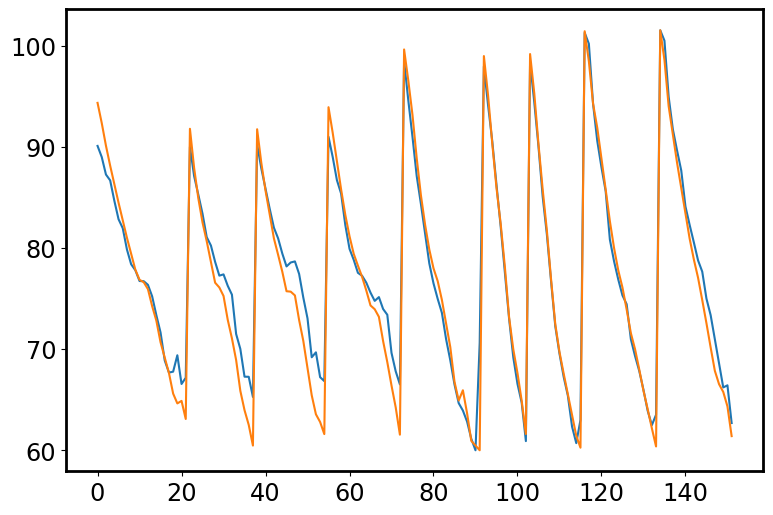

148/148 [==============================] - 2s 14ms/step
{'MAE_TR': [1.6382320931963121], 'MAPE_TR': [2.266846583246664], 'M_TR': [0.8416926029671128], 'T_TR': [0.9893301337540132], 'FC_TR': [0.91198444], 'MI_TR': [0.699682098180272], 'MAE_TS': [1.843957020728527], 'MAPE_TS': [2.544963781029103], 'M_TS': [0.9142857142857143], 'T_TS': [0.9968344155844155], 'FC_TS': [0.9023577], 'MI_TS': [0.6349006502440457], 'TIME': [248.10176753997803], 'I': [0]}


In [183]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_supervised_model(V_T, Current_windows, Cycles_windows,Cycles_windows_2, Units_windows, Y_windows,HI_windows,HI_windows,
                                                                                              V_T_test, Current_windows_test, Cycles_windows_test,Cycles_windows_2_test, Units_windows_test, Y_windows_test,HI_windows_test, HI_windows_test,
                                                                                              model,runs = 1, epochs = 20, batch_size=1024,learning_rate = 0.001,reset_weights=False)

In [184]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,1.638232,2.266847,0.841693,0.98933,0.911984,0.699682,1.843957,2.544964,0.914286,0.996834,0.902358,0.634901,248.101768,0


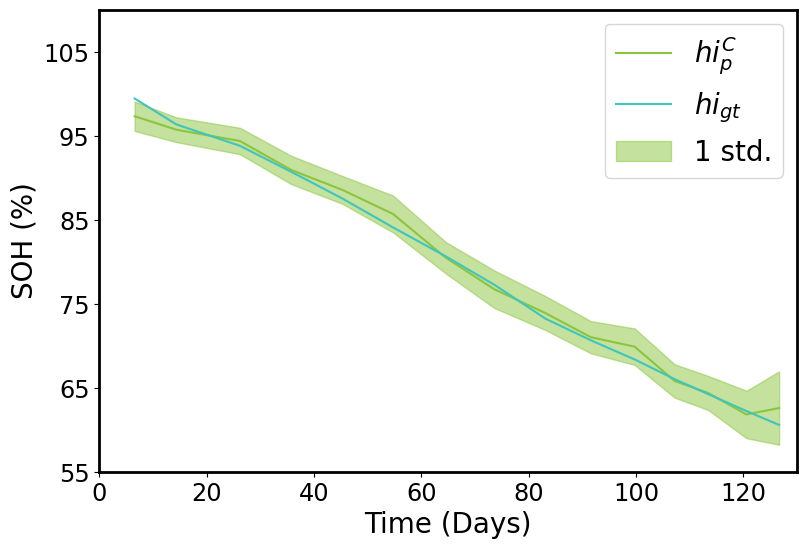

In [185]:
Unit = 20
run_id = 0
hh ,units_smooth, cycles_smooth = eval_utils.smooth_per_cycle(HI_windows_test,Cycles_windows_2_test[:,0],Units_windows_test)
hh = hh*100

t = Time_windows_test[:,0]
t = eval_utils.smooth_per_cycle(t,Cycles_windows_2_test[:,0],Units_windows_test)[0]
t = t/3600/24


idx2 = np.ravel(units_smooth==Unit)

fig = plt.figure()
plt.plot(t[idx2],z_test[run_id][idx2],'#8BC53F',label = r'$hi_{p}^C$')
plt.plot(t[idx2],hh[idx2],'#3FC5BC',label = r'$hi_{gt}$')

plt.fill_between(t[idx2],(z_test[run_id][idx2]-z_test_std[run_id][idx2]), 
                        (z_test[run_id][idx2]+z_test_std[run_id][idx2]), alpha = 0.5,color = '#8BC53F',label='1 std.')
plt.legend()
plt.xlabel('Time (Days)')
plt.ylabel('SOH (%)')
plt.ylim(55,110)
plt.xlim(0,130)
plt.yticks(np.arange(55, 115, 10))
plt.show()